# Plot the output of count_events.py

In [1]:
#import python packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import oskar

### Import data

In [6]:
rid = '20160314_193512'
h5 = oskar.h5_data(rid)             # data
out_dire = h5.out_dire("Count")     # output
# log 
h5.load_log()
logDF = h5.log
varDF = h5.vDF()
uDF = h5.uDF()
# count data
NAMES = ['CH_A0', 'CH_A1']
allDF = h5.load_count(NAMES, include_vars=True)

In [13]:
uDF.head()

,DLY_EA,IR,UV,VOL_u100,VOL_u101
VID,,,,,
1,5.950000e-07,739.83,243.2,2000,2000
2,5.950000e-07,750.70,243.2,2000,2000


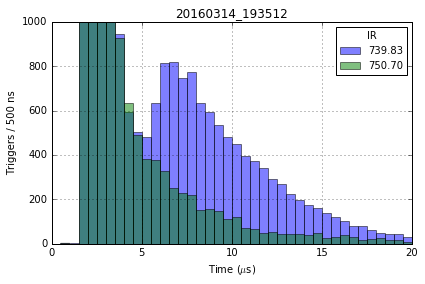

In [8]:
## plot setup
fig, ax = plt.subplots()
bin_width = 0.5
bins=np.arange(0.5,20 + bin_width, bin_width)

max_amp = 0.025
max_width = 0.5e-6

# select data
VIDS = [1, 2]
for vid in VIDS:
    # select data
    data = allDF[((allDF[uDF.columns] == uDF.loc[vid]).all(1))]
    # cut triggers
    data = data[(data['amp'] < max_amp) & (data['width'] < max_width)]
    trigs = (data['trigger'].values)*1e6
    ax.hist(trigs, bins=bins, alpha=0.5, label='%.2f'%uDF.loc[vid, 'IR'])
    
#format
plt.axhline(0, color='k', alpha=0.5)
lgd = ax.legend(loc=0, fontsize=10, title='IR')
ax.set_ylabel("Triggers / 500 ns");
ax.set_xlabel(r"Time ($\mu$s)");
ax.set_ylim(0,1000)
plt.title(rid);
ax.grid(True)

#save data
plt.tight_layout();
fileout = os.path.join(out_dire, "_".join(NAMES) + '_triggers.png')
plt.savefig(fileout, dpi=150)

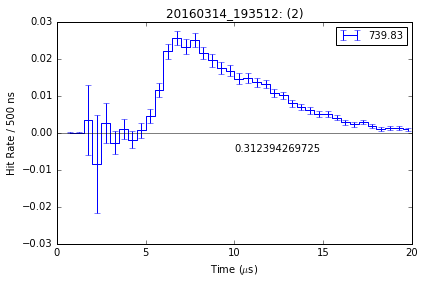

In [12]:
# histogram bins
bin_width = 0.5
bins=np.arange(0.5,20 + bin_width, bin_width)

# background
vid_off = 2
# select data
data = allDF[(allDF[uDF.columns] == uDF.loc[vid_off]).all(1)]
acq_off = logDF.loc[np.unique(data.squid.values), 'ACQUIRE'].sum()
# cut triggers
data = data[(data['amp'] < max_amp) & (data['width'] < max_width)]
trigs = (data['trigger'].values)*1e6
n_off = np.histogram(trigs, bins=bins)
x = n_off[1][:-1]+bin_width/2

# data
VIDS = [1]
n_rows = len(VIDS)
#plot setup
fig, ax = plt.subplots(n_rows, 1, figsize=(6,4*n_rows))
ax = np.array([ax]).flatten()
j = 0
hr = []
for vid in VIDS:
    # select data
    data = allDF[(allDF[uDF.columns] == uDF.loc[vid]).all(1)]
    acq_on = logDF.loc[np.unique(data.squid.values), 'ACQUIRE'].sum()
    # cut triggers
    data = data[(data['amp'] < max_amp) & (data['width'] < max_width)]
    trigs = (data['trigger'].values)*1e6
    n_on = np.histogram(trigs, bins=bins)
    # normalise and subtract background
    y =  np.subtract(n_on[0]/ acq_on, n_off[0] / acq_off)
    yerr  = np.add(np.sqrt(n_on[0])/ acq_on, np.sqrt(n_off[0])/ acq_off)
    ax[j].errorbar(x, y, yerr=yerr, drawstyle='steps-mid', label='%.2f'%uDF.loc[vid, 'IR'])
    ax[j].legend(loc=0, fontsize=10)
    ax[j].set_ylabel("Hit Rate / 500 ns")
    ax[j].axhline(0, color='k', alpha=0.5)
    ax[j].text(10, -0.005,y[5:].sum())
    hr.append(y[4:].sum())
    j = j + 1

# format
ax[-1].set_xlabel(r"Time ($\mu$s)");
ax[0].set_title(rid + ': (' + str(vid_off) + ')');

# save data
plt.tight_layout();
fileout = os.path.join(out_dire, "_".join(NAMES) + '_bsub.png')
plt.savefig(fileout, dpi=150)
plt.show()